## Practical Assessment - Deep Learning [100 Marks]


<div class="logos"><img src="Comp5625M_logo.jpg" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using DNN and CNN [70 Marks]
> 2. Use of RNN to predict texts for image captioning [30 Marks]

The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation 

Through this coursework, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem 
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage. 
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your full name: 

Shrichand Bhuria

### Part I: Image Classification [70 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[To submit your results on the Kaggle competition. You can also access data here](https://www.kaggle.com/t/9105198471a3490d9057026d27d8a711)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in the Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in the Kaggle. 

#### Submitting your test result to Kaggle leaderboard 
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [2]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url


import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader,Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
from torchsummary import summary

from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# always check your version
print(torch.__version__)

2.2.0


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation** [14 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (6 marks)

**2. Model training** [30 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (18 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks) 


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!-- 
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Function implementations [14 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, train=True, transform=None, validation_split=0.2, random_seed=42):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.images = []
        self.labels = []
        self.class_to_idx = {} 
        self.class_names = []  
        
        # Load dataset
        self.load_dataset(validation_split, random_seed)
        
    def load_dataset(self, validation_split, random_seed):
        class_idx = 0
        for class_label in os.listdir(self.data_dir):
            class_dir = os.path.join(self.data_dir, class_label)
            if os.path.isdir(class_dir):
                # Save class label to index mapping
                self.class_to_idx[class_label] = class_idx
                self.class_names.append(class_label)
                class_idx += 1
                
                # Traverse through the subdirectories of the class directory
                for root, _, files in os.walk(class_dir):
                    for img_file in files:
                        img_path = os.path.join(root, img_file)
                        if img_path.endswith(('.jpg', '.JPEG', '.png', '.bmp')):  
                            # Open image and ensure it has three channels
                            try:
                                img = Image.open(img_path).convert('RGB')
                                self.images.append(img)
                                self.labels.append(class_label)
                            except Exception as e:
                                print(f"Error loading image {img_path}: {e}")
        
        if not self.images:
            raise ValueError("No images found in the dataset directory.")
        
        # Combine images and labels into a single dataset
        dataset = list(zip(self.images, self.labels))
        
        # Calculate the number of samples for the validation set based on the available training samples
        total_samples = len(dataset)
        validation_samples = int(validation_split * total_samples)
        training_samples = total_samples - validation_samples
        
        # Set random seed for reproducibility
        torch.manual_seed(random_seed)
        
        if self.train:
            # Randomly split dataset into training and validation sets
            self.dataset, _ = random_split(dataset, [training_samples, validation_samples])
        else:
            # Keep only samples for validation set if loading validation data
            _, self.dataset = random_split(dataset, [training_samples, validation_samples])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
    
        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)
    
        # Map class label to index
        label_idx = self.class_to_idx[label]
    
        return img, label_idx
    
    def get_class_names(self):
        return self.class_names

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
]) 

# Define paths to train and test datasets
train_data_dir = '/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/comp5625M_data_assessment_1/train_set/train_set'


# Create train and validation datasets
train_dataset = ImageDataset(data_dir=train_data_dir, train=True, transform=transform, validation_split=0.2)
val_dataset = ImageDataset(data_dir=train_data_dir, train=False, transform=transform, validation_split=0.2)
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=0, shuffle=True, generator=torch.Generator().manual_seed(0))
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=0, shuffle=True)


# Print lengths of train and validation datasets
print("Length of train dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

# Get class names
class_names = train_dataset.get_class_names()
print("Class names:", class_names)


Length of train dataset: 10800
Length of validation dataset: 2700
Class names: ['butterfly', 'ladybug', 'pig', 'hourglass', 'mushroom', 'bee', 'fly', 'candle', 'goldfish', 'penguin', 'chihuahua', 'grasshopper', 'jellyfish', 'redpanda', 'icecream', 'ipod', 'umbrella', 'baboon', 'sombrero', 'koala', 'banana', 'pizza', 'refrigerator', 'cardigan', 'bison', 'espresso', 'lion', 'pretzel', 'goose', 'elephant']


### Display function of training dataset


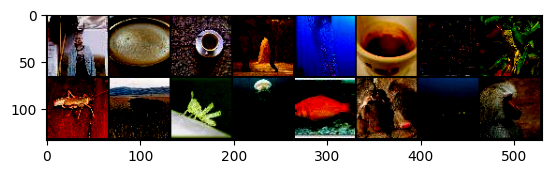

Labels: ['cardigan', 'espresso', 'espresso', 'elephant', 'jellyfish', 'espresso', 'refrigerator', 'grasshopper', 'grasshopper', 'bison', 'grasshopper', 'jellyfish', 'goldfish', 'baboon', 'fly', 'baboon']


In [7]:

def timshow(x):
    xa = np.transpose(x.numpy(), (1, 2, 0))
    # Clip pixel values to the range [0, 1]
    xa = np.clip(xa, 0, 1)
    plt.imshow(xa)
    plt.show()

def display_training_dataset(train_dataset, num_images=16, batch_size=4):
    
    # Get a batch of images and labels
    data_iter = iter(training_dataloader)
    images, labels = next(data_iter)
    
    # Display the images
    timshow(torchvision.utils.make_grid(images[:min(num_images, len(labels))]))
    
    # Map tensor indices to class names
    class_names = train_dataset.get_class_names()
    mapped_labels = [class_names[label.item()] for label in labels]
    
    # Print corresponding class names
    print("Labels:", mapped_labels)

display_training_dataset(train_dataset, num_images=16, batch_size=4)


### Display function of validation dataset


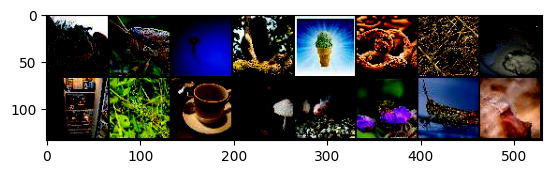

Labels: ['baboon', 'grasshopper', 'jellyfish', 'baboon', 'icecream', 'pretzel', 'fly', 'icecream', 'refrigerator', 'grasshopper', 'espresso', 'mushroom', 'goldfish', 'bee', 'grasshopper', 'baboon']


In [8]:

def timshow(x):
    xa = np.transpose(x.numpy(), (1, 2, 0))
    # Clip pixel values to the range [0, 1]
    xa = np.clip(xa, 0, 1)
    plt.imshow(xa)
    plt.show()

def display_val_dataset(val_dataset, num_images=16, batch_size=4):
    # Create DataLoader for the training dataset
    
    # Get a batch of images and labels
    data_iter = iter(validation_dataloader)
    images, labels = next(data_iter)
    
    # Display the images
    timshow(torchvision.utils.make_grid(images[:min(num_images, len(labels))]))
    
    # Map tensor indices to class names
    class_names = train_dataset.get_class_names()
    mapped_labels = [class_names[label.item()] for label in labels]
    
    # Print corresponding class names
    print("Labels:", mapped_labels)

# Call the display function
display_val_dataset(train_dataset, num_images=16, batch_size=4)

### 1.2 Define a MLP model class (4 marks)

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [6]:
class MLP(nn.Module):
    
    # initialize the MLP layers
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        
        # three fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        # Adding ReLU activation function
        self.relu = nn.ReLU()  
    
    # forward pass of the model
    def forward(self, x):
        out = x.reshape(x.shape[0],-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
    # the optimizer function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
    
    # returns the loss function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss() 


# prints an instance of the MLP class 
model = MLP(64 * 64 * 3, 1024, 512, 30)
print(model)

# prints number of parameters in the model
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_parameters}")

MLP(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=30, bias=True)
  (relu): ReLU()
)
Total parameters: 13124126


### 1.3 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [6]:
class CNN(nn.Module):
    
    # initialize the CNN layers
    def __init__(self,input_size, num_classes):
        super(CNN, self).__init__()
        
        # four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    # forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = torch.relu(self.bn4(self.conv4(out)))
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    # optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

In [6]:
# prints an instance of the MLP class 
model = CNN(8 * 8, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
)
Total parameters: 8518302


## 2 Model training [30 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [5]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

#### Define a fuction for plotting

In [7]:

def plotgraph(filename, num_epochs):
    
    data = pd.read_csv(filename)
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  #  figure size

    # Accuracy graph
    ax[0].plot(x, data['Training Accuracy'], label='Training', linestyle='-', color='green')  
    ax[0].plot(x, data['Validation Accuracy'], label='Validation', linestyle='--', color='red')  
    ax[0].set_title('Accuracy Graph', fontsize=16, fontweight='bold', color='blue')  
    ax[0].set_xlabel('No. of epochs', fontsize=14)  
    ax[0].set_ylabel('Accuracy', fontsize=14)  
    ax[0].legend(fontsize=12)  

    # Loss graph
    ax[1].plot(x, data['Training Loss'], label='Training', linestyle='-', color='green')  
    ax[1].plot(x, data['Validation Loss'], label='Validation', linestyle='--', color='red')  
    ax[1].set_title('Loss Graph', fontsize=16, fontweight='bold', color='blue')  
    ax[1].set_xlabel('No. of epochs', fontsize=14)  
    ax[1].set_ylabel('Loss', fontsize=14)  
    ax[1].legend(fontsize=12)  
    
    plt.tight_layout()  
    plt.show()


#### Train and Validate functions


In [8]:
# This training function will train the model with training dataset and 
# returns the training loss and accuracy after evaluation of the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_topk_accuracy = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_topk_accuracy / len(train_loader)
    
    return train_loss, train_acc

# This training function will evaluate the model with training dataset and 
# returns the training loss and accuracy after validation of the model
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    valid_topk_accuracy = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            valid_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
            
        val_loss = val_loss / len(val_loader)
        val_acc = valid_topk_accuracy / len(val_loader)
        
    return val_loss, val_acc

#### MLP Model


Epoch: 1/25 Train Loss: 3.1513, Train Accuracy: 12.20%, Validation Loss: 2.9589, Validation Accuracy: 16.41% 
Epoch: 2/25 Train Loss: 2.8197, Train Accuracy: 20.09%, Validation Loss: 2.8147, Validation Accuracy: 19.02% 
Epoch: 3/25 Train Loss: 2.6506, Train Accuracy: 24.51%, Validation Loss: 2.7405, Validation Accuracy: 21.91% 
Epoch: 4/25 Train Loss: 2.4973, Train Accuracy: 29.22%, Validation Loss: 2.7708, Validation Accuracy: 20.99% 
Epoch: 5/25 Train Loss: 2.3517, Train Accuracy: 33.47%, Validation Loss: 2.6782, Validation Accuracy: 22.52% 
Epoch: 6/25 Train Loss: 2.1768, Train Accuracy: 38.68%, Validation Loss: 2.6887, Validation Accuracy: 23.11% 
Epoch: 7/25 Train Loss: 1.9907, Train Accuracy: 44.29%, Validation Loss: 2.7105, Validation Accuracy: 23.13% 
Epoch: 8/25 Train Loss: 1.7888, Train Accuracy: 50.77%, Validation Loss: 2.7810, Validation Accuracy: 22.65% 
Epoch: 9/25 Train Loss: 1.5556, Train Accuracy: 57.41%, Validation Loss: 2.8853, Validation Accuracy: 22.78% 
Epoch: 10/

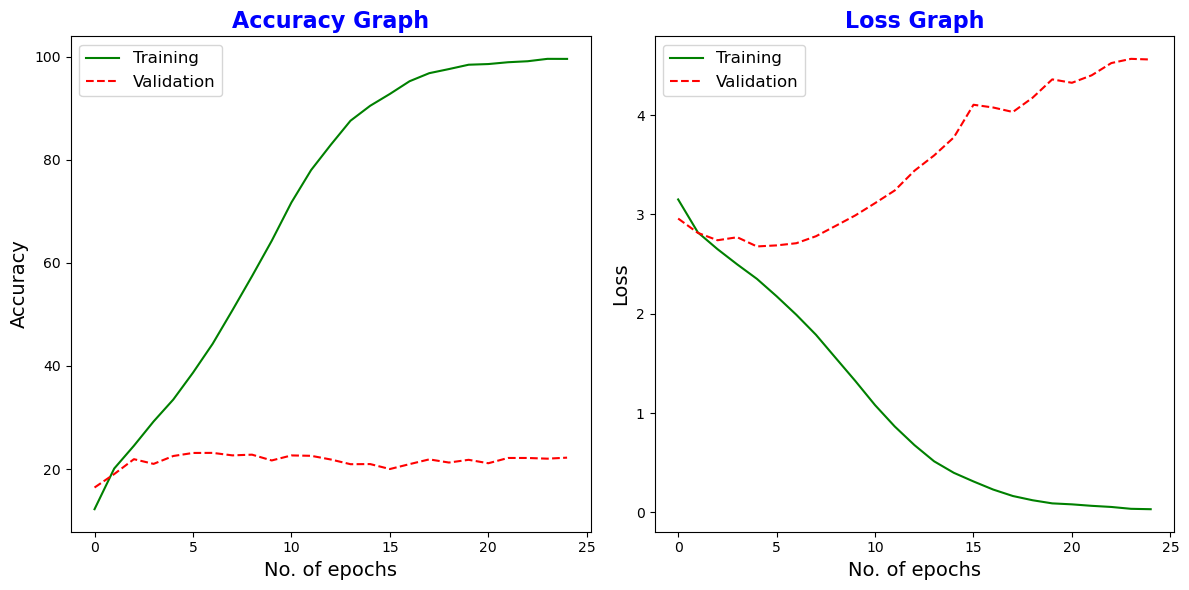

In [23]:
# This function will train and validate the model for specific number of epochs
def mlp_model_train(model, num_epochs, lr ,filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    

    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Creating an instance of the MLP class 
mlp_model = MLP(input_size=64*64*3, hidden_size1=1024, hidden_size2=512, num_classes=30).to(device)

# Train the MLP model with 25 epochs and a learning rate of 0.001
mlp_model_train(mlp_model, num_epochs=25, lr=0.001, filename="mlp_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename="mlp_basemodel.csv", num_epochs=25)

#### CNN Model

Epoch: 1/25 Train Loss: 2.7067, Train Accuracy: 23.10%, Validation Loss: 2.3613, Validation Accuracy: 30.94% 
Epoch: 2/25 Train Loss: 2.1167, Train Accuracy: 38.31%, Validation Loss: 2.1444, Validation Accuracy: 37.96% 
Epoch: 3/25 Train Loss: 1.8037, Train Accuracy: 47.50%, Validation Loss: 2.0300, Validation Accuracy: 42.12% 
Epoch: 4/25 Train Loss: 1.5374, Train Accuracy: 54.97%, Validation Loss: 1.9588, Validation Accuracy: 44.08% 
Epoch: 5/25 Train Loss: 1.2919, Train Accuracy: 61.92%, Validation Loss: 2.0463, Validation Accuracy: 43.58% 
Epoch: 6/25 Train Loss: 1.0477, Train Accuracy: 69.15%, Validation Loss: 1.9397, Validation Accuracy: 45.85% 
Epoch: 7/25 Train Loss: 0.8043, Train Accuracy: 76.57%, Validation Loss: 1.9136, Validation Accuracy: 47.73% 
Epoch: 8/25 Train Loss: 0.5651, Train Accuracy: 84.69%, Validation Loss: 2.0544, Validation Accuracy: 46.13% 
Epoch: 9/25 Train Loss: 0.3836, Train Accuracy: 90.69%, Validation Loss: 2.0355, Validation Accuracy: 47.45% 
Epoch: 10/

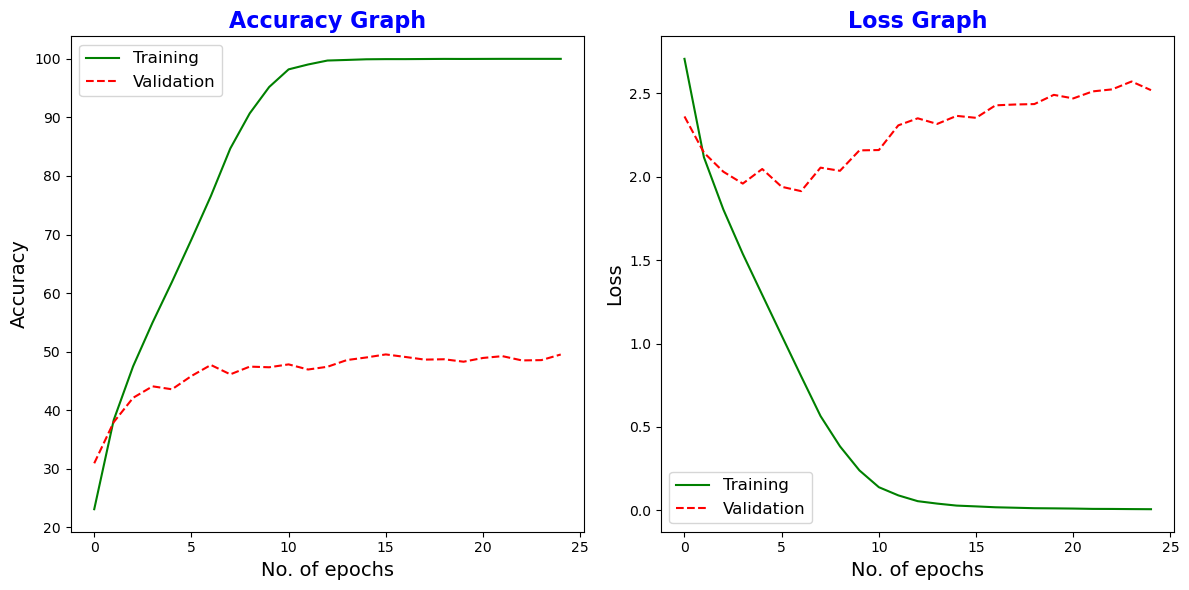

In [24]:
# This function will train and validate the model for specific number of epochs
def cnn_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
# Creating an instance of the CNN class 
cnn_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 25 epochs and a learning rate of 0.001
cnn_model_train(cnn_model, num_epochs = 25, lr = 0.001, filename = "cnn_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_basemodel.csv", num_epochs = 25)

#### Why CNN is better than MLP for image classification?

The MLP model has three layers that are fully connected. It's not very good at recognizing patterns in images, with a validation accuracy of only 23%. Also, it's pretty complicated, with 13.1 million parts, making it tough to train.

On the other hand, the CNN model has four layers for convolutions and two fully connected layers. Its validation accuracy is around 50%, which is better than the MLP model. Plus, it's less complicated, with only about 8.5 million parts. The CNN model works by finding patterns and features in the images using convolutional layers, which helps it classify pictures better.

Even though we trained both models for 25 rounds, looking at the graphs, we see that they both hit their best performance before reaching the maximum rounds. For the MLP model, it's around 20 rounds, and for the CNN model, it's around 15. This means we didn't see much improvement after these points.

> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [25]:
def get_conf_rocc(model, train_loader, valid_loader, classes):
   
    model.to(device)

    # Get predictions and true labels for training set
    model.eval()
    train_preds = []
    train_true = []
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            train_preds += pred.cpu().numpy().tolist()
            train_true += target.cpu().numpy().tolist()

    # Get predictions and true labels for validation set
    valid_preds = []
    valid_true = []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            valid_preds += pred.cpu().numpy().tolist()
            valid_true += target.cpu().numpy().tolist()

    # Calculate confusion matrices for training and validation sets
    train_cm = confusion_matrix(train_true, train_preds)
    valid_cm = confusion_matrix(valid_true, valid_preds)

    # Plotting the heat map of confusion matrix for training dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(train_cm/train_cm.sum(axis=1)[:, np.newaxis], cmap = 'viridis', vmin = 0, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, annot_kws={'fontsize': 8})
    plt.xlabel('Predicted', fontsize=14, fontweight='bold', color='blue')
    plt.ylabel('True', fontsize=14, fontweight='bold', color='blue')
    plt.title('Confusion Matrix - Training Set', fontsize=16, fontweight='bold', color='green')

    plt.show()


    # Plotting the heat map of confusion matrix for validation dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(valid_cm/valid_cm.sum(axis=1)[:, np.newaxis], cmap = 'viridis', vmin = 0, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, annot_kws={'fontsize': 8})
    plt.xlabel('Predicted', fontsize=14, fontweight='bold', color='blue')
    plt.ylabel('True', fontsize=14, fontweight='bold', color='blue')
    plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold', color='green')
    plt.show()

    # Plot ROC curves for top five classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    top_classes1 = sorted(range(len(classes)), key=lambda i: -valid_cm[i, i])[:2]
    top_classes2 = sorted(range(len(classes)), key=lambda i: -valid_cm[i, i])[-2:]
    top_classes3=top_classes1+top_classes2
    for i in top_classes3:
        class_preds = []
        class_true = []
        for j in range(len(valid_true)):
            if valid_true[j] == i:
                class_preds.append(valid_preds[j])
                class_true.append(1)
            else:
                class_preds.append(valid_preds[j])
                class_true.append(0)
        fpr[i], tpr[i], _ = roc_curve(class_true, class_preds)
        roc_auc[i] = auc(fpr[i], tpr[i])    
    
    # Plot ROC curves
    for i in top_classes3:
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]), color='C{}'.format(i))  
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)  
    plt.ylabel('True Positive Rate', fontsize=12)  
    plt.title('ROC curves for top 2 classes and bottom 2', fontsize=14)  
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, prop={'size': 8})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



#### Confusion Matrix and ROC curve for base CNN model


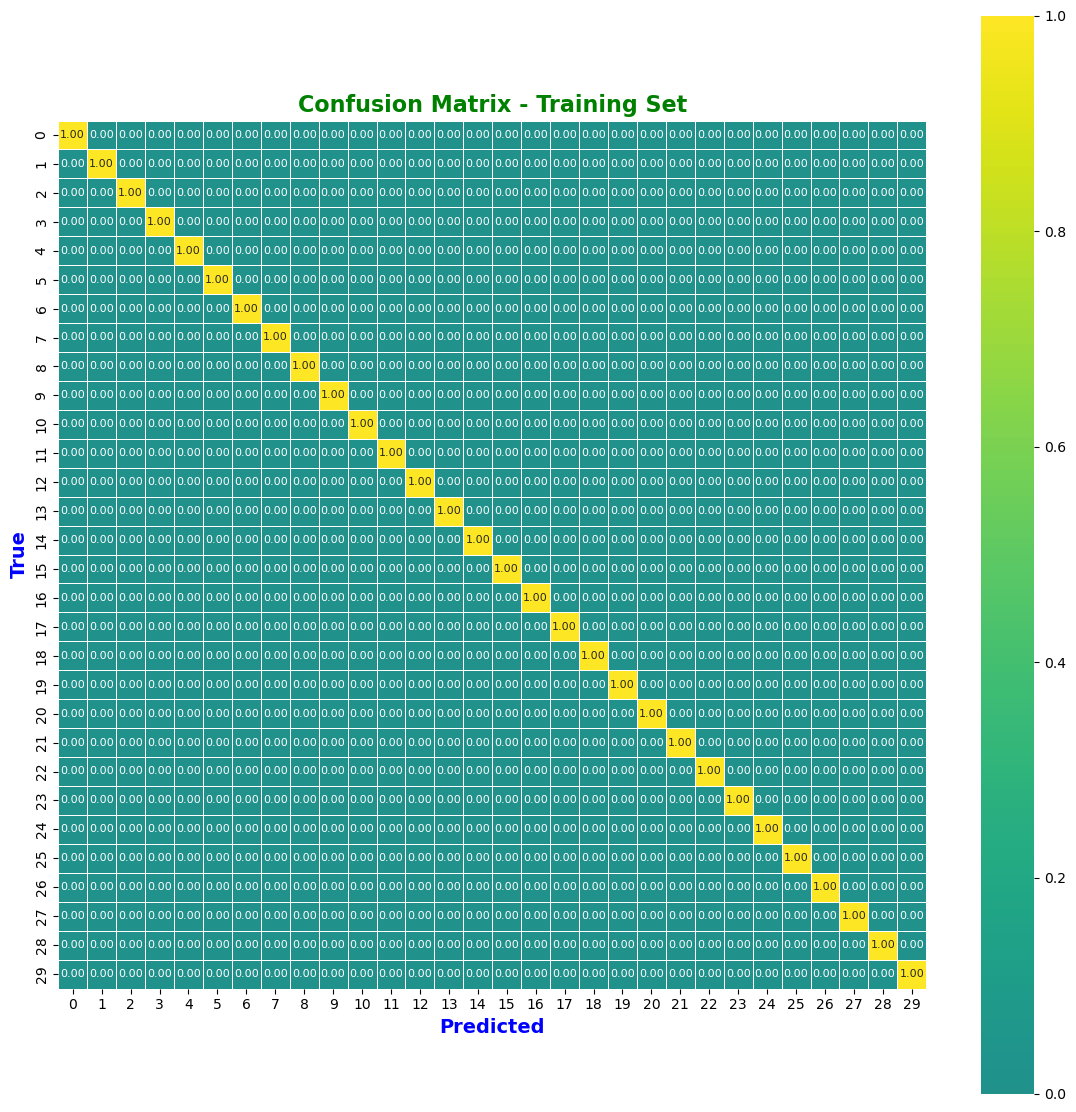

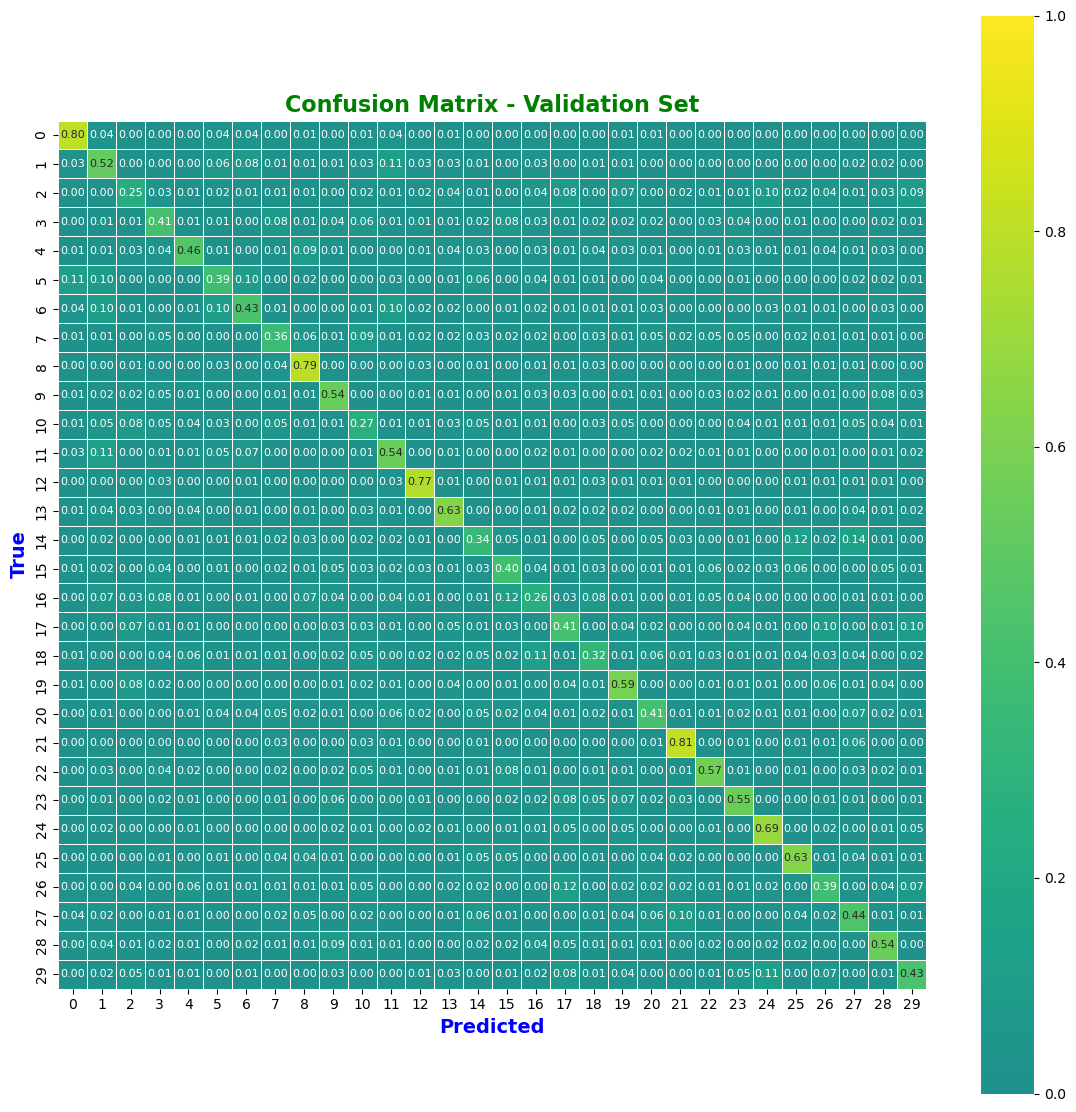

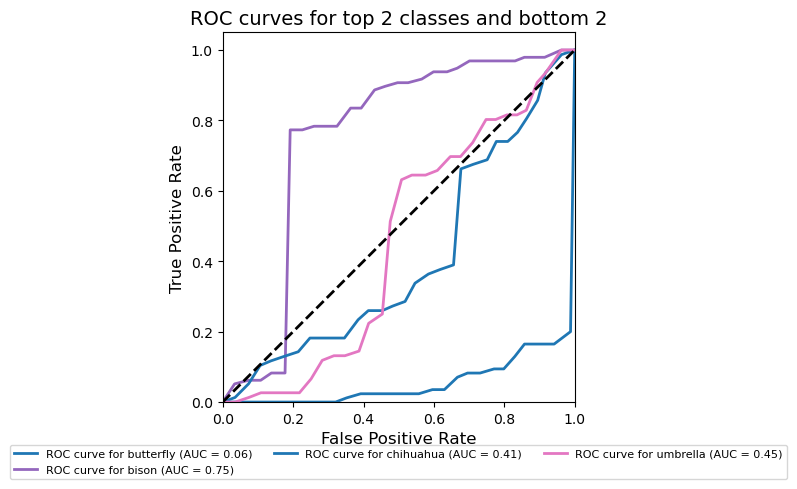

In [26]:
get_conf_rocc(cnn_model, training_dataloader, validation_dataloader, class_names)


### Redesign your CNN model (optional)
> This is optional and does not carry any marks. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish. 

In [27]:
# Your code here (optional)

**Note: All questions below here relates to the CNN model only and not an MLP model! You are advised to use your final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting (18 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (6 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graphs and comment on what you observe.


In [9]:
# data augementation techniques for the dataset
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.ColorJitter(hue=0.1, saturation=0.5, brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(4),
    transforms.RandomAutocontrast(0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.GaussianBlur(3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = ImageDataset(data_dir=train_data_dir, train=True, transform=train_transform, validation_split=0.2)
val_dataset = ImageDataset(data_dir=train_data_dir, train=False, transform=train_transform, validation_split=0.2)
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=0, shuffle=True, generator=torch.Generator().manual_seed(0))
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=0, shuffle=True)

class_names = train_dataset.get_class_names()


Epoch: 1/25 Train Loss: 2.9821, Train Accuracy: 16.00%, Validation Loss: 2.8186, Validation Accuracy: 20.34% 
Epoch: 2/25 Train Loss: 2.5987, Train Accuracy: 25.80%, Validation Loss: 2.6073, Validation Accuracy: 25.86% 
Epoch: 3/25 Train Loss: 2.4019, Train Accuracy: 31.69%, Validation Loss: 2.4822, Validation Accuracy: 29.36% 
Epoch: 4/25 Train Loss: 2.2650, Train Accuracy: 35.08%, Validation Loss: 2.3645, Validation Accuracy: 33.33% 
Epoch: 5/25 Train Loss: 2.1340, Train Accuracy: 38.34%, Validation Loss: 2.2989, Validation Accuracy: 33.70% 
Epoch: 6/25 Train Loss: 2.0217, Train Accuracy: 41.38%, Validation Loss: 2.2258, Validation Accuracy: 36.64% 
Epoch: 7/25 Train Loss: 1.9302, Train Accuracy: 43.84%, Validation Loss: 2.0895, Validation Accuracy: 39.99% 
Epoch: 8/25 Train Loss: 1.8490, Train Accuracy: 46.15%, Validation Loss: 2.0746, Validation Accuracy: 40.83% 
Epoch: 9/25 Train Loss: 1.7735, Train Accuracy: 47.63%, Validation Loss: 2.0673, Validation Accuracy: 40.94% 
Epoch: 10/

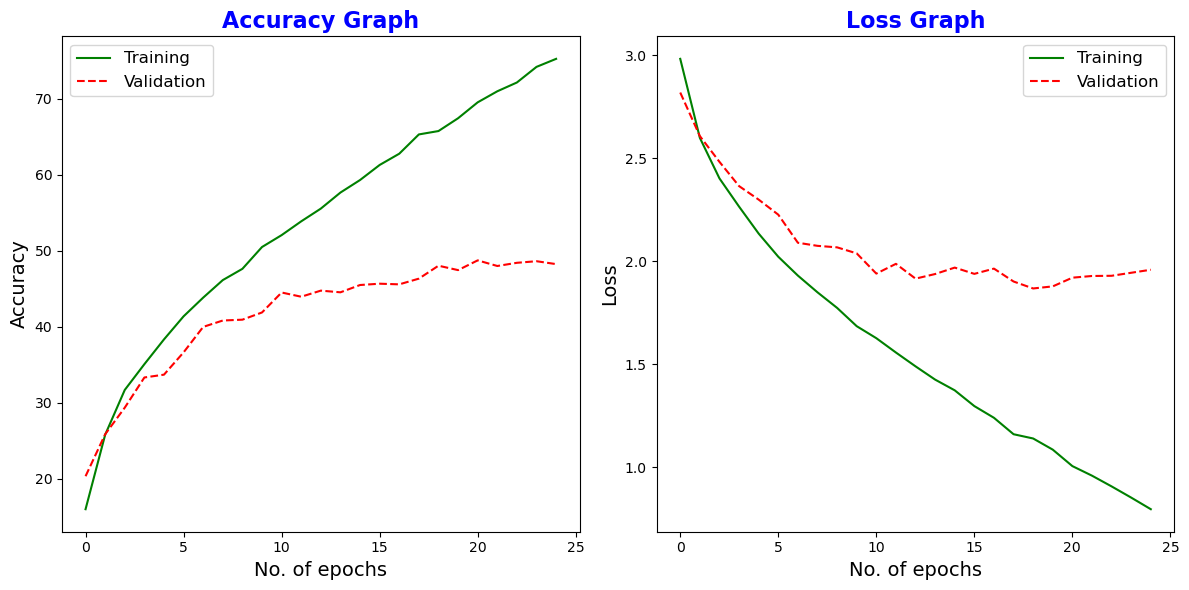

In [29]:
# instance of the CNN class 
cnn_augmentation_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_model_train(cnn_augmentation_model, num_epochs = 25, lr = 0.001, filename = "cnn_dataaugmentationmodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dataaugmentationmodel.csv", num_epochs = 25)

#### CNN Model after using data augmentation:

After trying out different data augmentation methods, the CNN model didn't seem to get much better compared to the original one. While the validation loss went down a bit at first, it started going up again as the validation accuracy leveled off. We tried fine-tuning the model by using the weights from the previous version, but it ended up making the model overfit. So, based on what we saw, this might not be the best model for what we're trying to do.

#### 2.3.2 Dropout (6 marks)

> Implement dropout in your model 

> Provide graphs and comment on your choice of proportion used.

In [12]:
class CNN_DropOut(nn.Module):
    def __init__(self,input_size, num_classes, dropout_prob=0.5):
        super(CNN_DropOut, self).__init__()
        # Defining the four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Adding drop out function
        self.dropout = nn.Dropout(dropout_prob)

    # Defining the forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.dropout(out)
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = self.dropout(out)
        out = torch.relu(self.bn4(self.conv4(out)))
        out = self.dropout(out)
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    # This function returns the optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # This function returns the loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

Epoch: 1/30 Train Loss: 3.3349, Train Accuracy: 6.68%, Validation Loss: 3.2295, Validation Accuracy: 8.93% 
Epoch: 2/30 Train Loss: 3.1199, Train Accuracy: 12.18%, Validation Loss: 3.0244, Validation Accuracy: 13.26% 
Epoch: 3/30 Train Loss: 2.9829, Train Accuracy: 15.14%, Validation Loss: 2.9315, Validation Accuracy: 17.28% 
Epoch: 4/30 Train Loss: 2.8847, Train Accuracy: 17.69%, Validation Loss: 2.8434, Validation Accuracy: 17.60% 
Epoch: 5/30 Train Loss: 2.8206, Train Accuracy: 19.51%, Validation Loss: 2.7865, Validation Accuracy: 19.81% 
Epoch: 6/30 Train Loss: 2.7499, Train Accuracy: 21.22%, Validation Loss: 2.8667, Validation Accuracy: 19.21% 
Epoch: 7/30 Train Loss: 2.6922, Train Accuracy: 22.59%, Validation Loss: 2.8287, Validation Accuracy: 19.46% 
Epoch: 8/30 Train Loss: 2.6573, Train Accuracy: 24.09%, Validation Loss: 2.7412, Validation Accuracy: 22.88% 
Epoch: 9/30 Train Loss: 2.6153, Train Accuracy: 25.44%, Validation Loss: 2.6221, Validation Accuracy: 25.90% 
Epoch: 10/30

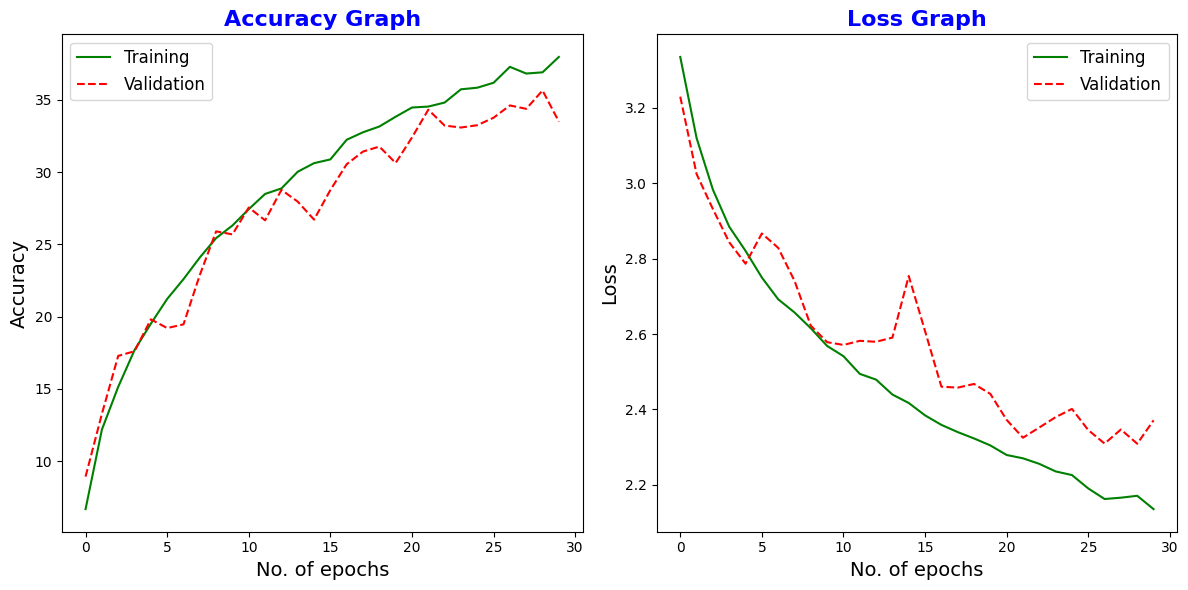

In [13]:
# This function will train and validate the model for specific number of epochs
def cnn_dropmodel_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
    
# Creating an instance of the CNN class 
cnn_dropmodel = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_dropmodel, num_epochs = 30, lr = 0.001, filename = "cnn_dropmodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dropmodel.csv", num_epochs = 30)

#### Feedback on CNN Model with Dropout:

Using dropout regularization in the CNN model has proven to be highly effective. This model performs better than others because it maintains consistent accuracy levels for both the training and validation datasets. Initially, the training loss may be slightly higher than the validation loss, but this evens out over time as the model continues to train. Notably, the dropout CNN model exhibits no signs of overfitting or underfitting after the initial training epochs, indicating its strong performance. As a result, I consider this model to be the best option. After experimenting with different dropout proportions, a proportion of 0.5 was found to be the most optimal choice

#### 2.3.3 Hyperparameter tuning (6 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

#### CNN model with learing rate 0.1


In [32]:
# Creating an instance of the CNN class 
cnn_model_lr1 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.1
cnn_dropmodel_train(cnn_model_lr1, num_epochs = 25, lr = 0.1, filename = "cnn_lr1_model.csv")

Epoch: 1/25 Train Loss: 3.4911, Train Accuracy: 3.36%, Validation Loss: 3.4227, Validation Accuracy: 3.21% 
Epoch: 2/25 Train Loss: 3.4173, Train Accuracy: 3.26%, Validation Loss: 3.4211, Validation Accuracy: 2.86% 
Epoch: 3/25 Train Loss: 3.4171, Train Accuracy: 3.08%, Validation Loss: 3.4120, Validation Accuracy: 3.45% 
Epoch: 4/25 Train Loss: 3.4183, Train Accuracy: 3.56%, Validation Loss: 3.4138, Validation Accuracy: 2.92% 
Epoch: 5/25 Train Loss: 3.4176, Train Accuracy: 3.32%, Validation Loss: 3.4122, Validation Accuracy: 3.29% 
Epoch: 6/25 Train Loss: 3.4193, Train Accuracy: 2.81%, Validation Loss: 3.4190, Validation Accuracy: 2.85% 
Epoch: 7/25 Train Loss: 3.4164, Train Accuracy: 3.48%, Validation Loss: 3.4247, Validation Accuracy: 3.30% 
Epoch: 8/25 Train Loss: 3.4169, Train Accuracy: 3.39%, Validation Loss: 3.4171, Validation Accuracy: 3.74% 
Epoch: 9/25 Train Loss: 3.4161, Train Accuracy: 3.62%, Validation Loss: 3.4205, Validation Accuracy: 3.11% 
Epoch: 10/25 Train Loss: 3.4

### CNN model with learing rate 0.001


In [33]:
# Creating an instance of the CNN class 
cnn_model_lr001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_model_lr001, num_epochs = 25, lr = 0.001, filename = "cnn_lr001_model.csv")


Epoch: 1/25 Train Loss: 3.2936, Train Accuracy: 7.86%, Validation Loss: 3.2113, Validation Accuracy: 9.10% 
Epoch: 2/25 Train Loss: 3.0933, Train Accuracy: 12.77%, Validation Loss: 3.0778, Validation Accuracy: 13.46% 
Epoch: 3/25 Train Loss: 2.9878, Train Accuracy: 14.87%, Validation Loss: 3.0214, Validation Accuracy: 15.84% 
Epoch: 4/25 Train Loss: 2.9230, Train Accuracy: 17.11%, Validation Loss: 2.8944, Validation Accuracy: 17.54% 
Epoch: 5/25 Train Loss: 2.8632, Train Accuracy: 17.62%, Validation Loss: 2.8729, Validation Accuracy: 17.81% 
Epoch: 6/25 Train Loss: 2.8126, Train Accuracy: 19.88%, Validation Loss: 2.8732, Validation Accuracy: 18.69% 
Epoch: 7/25 Train Loss: 2.7694, Train Accuracy: 20.80%, Validation Loss: 2.8533, Validation Accuracy: 20.16% 
Epoch: 8/25 Train Loss: 2.7182, Train Accuracy: 22.23%, Validation Loss: 2.7646, Validation Accuracy: 22.18% 
Epoch: 9/25 Train Loss: 2.6805, Train Accuracy: 23.40%, Validation Loss: 2.7791, Validation Accuracy: 20.78% 
Epoch: 10/25

### CNN model with learing rate 0.0001


In [34]:
# Creating an instance of the CNN class 
cnn_model_lr0001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.0001
cnn_dropmodel_train(cnn_model_lr0001, num_epochs = 25, lr = 0.0001, filename = "cnn_lr0001_model.csv")


Epoch: 1/25 Train Loss: 3.4273, Train Accuracy: 3.71%, Validation Loss: 3.3812, Validation Accuracy: 7.51% 
Epoch: 2/25 Train Loss: 3.3884, Train Accuracy: 4.88%, Validation Loss: 3.3502, Validation Accuracy: 7.40% 
Epoch: 3/25 Train Loss: 3.3335, Train Accuracy: 6.69%, Validation Loss: 3.2969, Validation Accuracy: 8.53% 
Epoch: 4/25 Train Loss: 3.2730, Train Accuracy: 8.07%, Validation Loss: 3.2342, Validation Accuracy: 9.70% 
Epoch: 5/25 Train Loss: 3.2306, Train Accuracy: 8.83%, Validation Loss: 3.2150, Validation Accuracy: 9.64% 
Epoch: 6/25 Train Loss: 3.1994, Train Accuracy: 9.77%, Validation Loss: 3.1939, Validation Accuracy: 10.54% 
Epoch: 7/25 Train Loss: 3.1757, Train Accuracy: 10.04%, Validation Loss: 3.1626, Validation Accuracy: 10.69% 
Epoch: 8/25 Train Loss: 3.1381, Train Accuracy: 11.49%, Validation Loss: 3.1166, Validation Accuracy: 11.06% 
Epoch: 9/25 Train Loss: 3.1022, Train Accuracy: 12.37%, Validation Loss: 3.1063, Validation Accuracy: 11.21% 
Epoch: 10/25 Train Lo

### Comparsion graph for three different learning rates


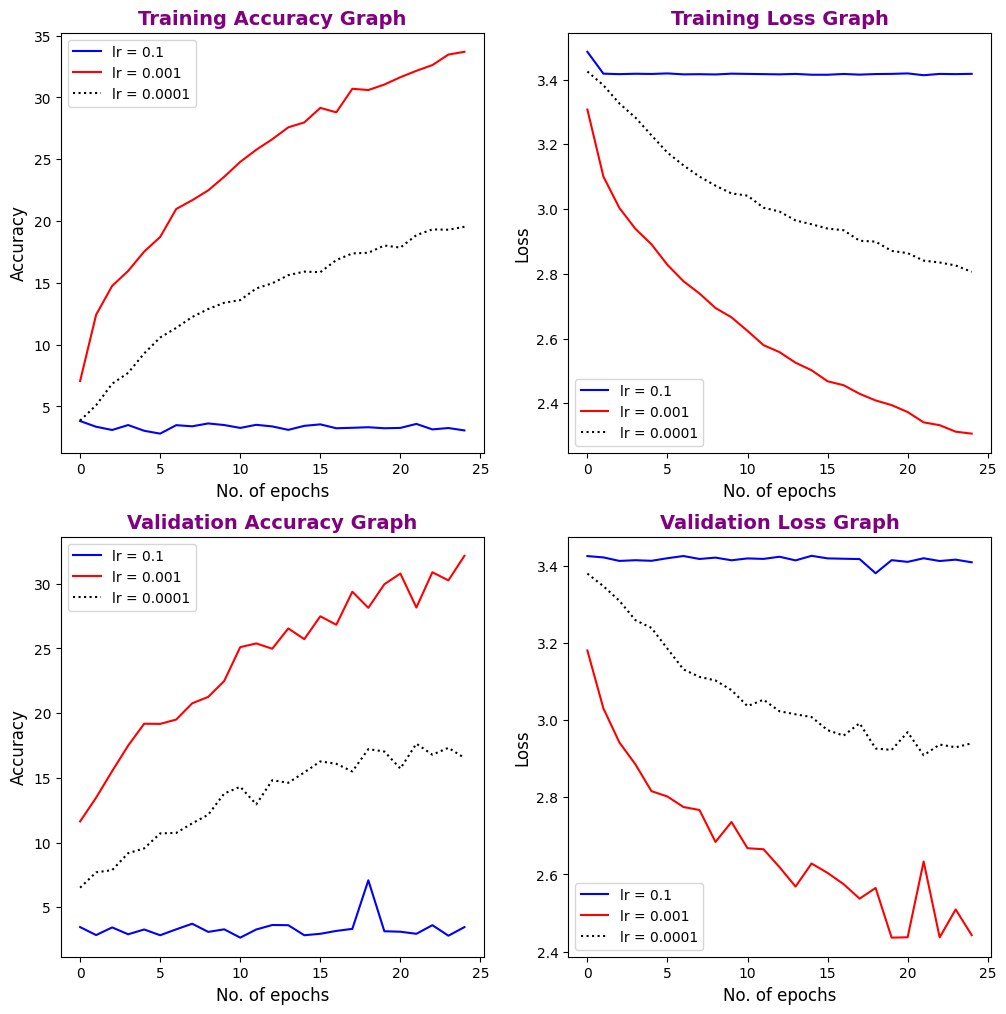

In [63]:
# Graphs for Hyper parameter tuning models
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph_learningrates(filename_1, filename_2, filename_3, num_epochs):
    
    data_1 = pd.read_csv(filename_1)
    data_2 = pd.read_csv(filename_2)
    data_3 = pd.read_csv(filename_3)
        
    x = np.arange(num_epochs)
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    # Training Accuracy Graph
    ax[0, 0].plot(x, data_1['Training Accuracy'], label='lr = 0.1', linestyle='-', color='blue')
    ax[0, 0].plot(x, data_2['Training Accuracy'], label='lr = 0.001', linestyle='-', color='red')
    ax[0, 0].plot(x, data_3['Training Accuracy'], label='lr = 0.0001', linestyle=':', color='black')
    ax[0, 0].set_title('Training Accuracy Graph', fontsize=14, fontweight='bold', color='purple')
    ax[0, 0].set_xlabel('No. of epochs', fontsize=12)
    ax[0, 0].set_ylabel('Accuracy', fontsize=12)
    ax[0, 0].legend(loc='upper left', fontsize=10)

    # Training Loss Graph
    ax[0, 1].plot(x, data_1['Training Loss'], label='lr = 0.1', linestyle='-', color='blue')
    ax[0, 1].plot(x, data_2['Training Loss'], label='lr = 0.001', linestyle='-', color='red')
    ax[0, 1].plot(x, data_3['Training Loss'], label='lr = 0.0001', linestyle=':', color='black')
    ax[0, 1].set_title('Training Loss Graph', fontsize=14, fontweight='bold', color='purple')
    ax[0, 1].set_xlabel('No. of epochs', fontsize=12)
    ax[0, 1].set_ylabel('Loss', fontsize=12)
    ax[0, 1].legend(loc='lower left', fontsize=10)

    # Validation Accuracy Graph
    ax[1, 0].plot(x, data_1['Validation Accuracy'], label='lr = 0.1', linestyle='-', color='blue')
    ax[1, 0].plot(x, data_2['Validation Accuracy'], label='lr = 0.001', linestyle='-', color='red')
    ax[1, 0].plot(x, data_3['Validation Accuracy'], label='lr = 0.0001', linestyle=':', color='black')
    ax[1, 0].set_title('Validation Accuracy Graph', fontsize=14, fontweight='bold', color='purple')
    ax[1, 0].set_xlabel('No. of epochs', fontsize=12)
    ax[1, 0].set_ylabel('Accuracy', fontsize=12)
    ax[1, 0].legend(loc='upper left', fontsize=10)

    # Validation Loss Graph
    ax[1, 1].plot(x, data_1['Validation Loss'], label='lr = 0.1', linestyle='-', color='blue')
    ax[1, 1].plot(x, data_2['Validation Loss'], label='lr = 0.001', linestyle='-', color='red')
    ax[1, 1].plot(x, data_3['Validation Loss'], label='lr = 0.0001', linestyle=':', color='black')
    ax[1, 1].set_title('Validation Loss Graph', fontsize=14, fontweight='bold', color='purple')
    ax[1, 1].set_xlabel('No. of epochs', fontsize=12)
    ax[1, 1].set_ylabel('Loss', fontsize=12)
    ax[1, 1].legend(loc='lower left', fontsize=10)

    plt.show()

 


plotgraph_learningrates(filename_1 = "cnn_lr1_model.csv", filename_2 = "cnn_lr001_model.csv", 
                        filename_3 = "cnn_lr0001_model.csv", num_epochs = 25)

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set. 

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [14]:
# Class for loading test datasets
class TestFolderData(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_names = os.listdir(self.folder_path)
        
    # This function returns the number of samples in the dataset
    def __len__(self):
        return len(self.file_names)
    
    # This function returns the image and the image file name.
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_names[idx])
        image =  torchvision.datasets.folder.default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return self.file_names[idx],image

#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks]. 


In [15]:
# This function will evaluate the test data and save the result in CSV file with image file name and predicted label
def generate_predictions(model, test_dataloader, output_file):
    model.eval()
    model.to(device)

    predictions = []
    file_names = []

    for batch, (file_name, images) in enumerate(test_dataloader):
        images = images.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        file_names.extend(file_name)

    # Create a dataframe with the file names and predictions, and save the results to a CSV file
    results_df = pd.DataFrame({'Id': file_names, 'Category': predictions})
    results_df.to_csv(output_file, index=False)


In [16]:
# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset of images and apply the transformation
data_dir = '/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/comp5625M_data_assessment_1/test_set/test_set'
dataset = TestFolderData(data_dir , transform=transform)

# Create a DataLoader for the testing set
testdataloader = DataLoader(dataset, batch_size=12, shuffle=False, num_workers= 0)

# This function will evaluate the test data
generate_predictions(cnn_dropmodel, testdataloader, 'mm232sb.csv')

### Display function of testing dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


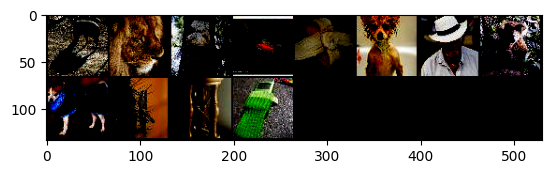

('c5693b7d_ab8f.JPEG', '9e70a764_2962.JPEG', 'b54e8c45_5503.JPEG', 'fe6b0876_df17.JPEG', 'e57c80f8_247c.JPEG', 'e22a4256_3ada.JPEG', '4f8af6a9_5994.JPEG', '7b8e1487_9661.JPEG', 'dd8a6980_4f56.JPEG', '28da5d54_8f9c.JPEG', 'baefd2d6_f17a.JPEG', '91304362_779c.JPEG')


In [19]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(testdataloader)
filename, images = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
# print(f"labels {[filename[labels[i]] for i in range(16)]}")
print(filename)



### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [12]:
# Define the image preprocessing steps
cifar_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download and load the CIFAR10 dataset
cifar_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

# Set the random seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Splitting the dataset for validation and training in an 80:20 ratio     
cifar_train_size = int(0.8 * len(cifar_train_data))
cifar_val_size = len(cifar_train_data) - cifar_train_size
cifar_train_data, cifar_val_data = torch.utils.data.random_split(cifar_train_data, [cifar_train_size, cifar_val_size])

# Create data loaders
batch_size = 64
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True, num_workers= 0,
                                                 generator=torch.Generator().manual_seed(0))
cifar_val_loader = torch.utils.data.DataLoader(cifar_val_data, batch_size=batch_size, shuffle=False, num_workers= 0)

Files already downloaded and verified


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [13]:
#  Loading the pretrained alexnet model and the normal alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
alexnet = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
alexnet.load_state_dict(alexnet_pretrained.state_dict())

# Modify the last layer for CIFAR-10 classification
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)

alexnet = alexnet.to(device)


# printing the summary of the number of parameters 
summary(alexnet, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]          23,296
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [16]:
# This function will train and validate cifar data  over the alex model for specific number of epochs 
def cifar_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    
    train_loader = cifar_train_loader
    val_loader = cifar_val_loader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Train the AlexNet model over the CIFAR-10 with 25 epochs and a learning rate of 0.001
cifar_model_train(alexnet, num_epochs = 25, lr = 0.001, filename = "cifar_results.csv")

Epoch: 1/25 Train Loss: 1.1075, Train Accuracy: 60.51%, Validation Loss: 0.8939, Validation Accuracy: 68.28% 
Epoch: 2/25 Train Loss: 0.8941, Train Accuracy: 67.89%, Validation Loss: 0.8086, Validation Accuracy: 71.04% 
Epoch: 3/25 Train Loss: 0.8198, Train Accuracy: 71.05%, Validation Loss: 0.7778, Validation Accuracy: 72.99% 
Epoch: 4/25 Train Loss: 0.7824, Train Accuracy: 72.56%, Validation Loss: 0.7516, Validation Accuracy: 72.95% 
Epoch: 5/25 Train Loss: 0.7495, Train Accuracy: 73.71%, Validation Loss: 0.7647, Validation Accuracy: 72.89% 
Epoch: 6/25 Train Loss: 0.7181, Train Accuracy: 74.80%, Validation Loss: 0.6989, Validation Accuracy: 75.35% 
Epoch: 7/25 Train Loss: 0.7004, Train Accuracy: 75.22%, Validation Loss: 0.7171, Validation Accuracy: 74.61% 
Epoch: 8/25 Train Loss: 0.6864, Train Accuracy: 75.85%, Validation Loss: 0.6812, Validation Accuracy: 76.30% 
Epoch: 9/25 Train Loss: 0.6690, Train Accuracy: 76.53%, Validation Loss: 0.7075, Validation Accuracy: 75.48% 
Epoch: 10/

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [16]:
# This function will train and validate cifar data  over the alex model for specific number of epochs 
def cifar_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    
    train_loader = cifar_train_loader
    val_loader = cifar_val_loader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

In [17]:
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
frozen_model = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
frozen_model.load_state_dict(alexnet_pretrained.state_dict())

# The frozen_model will have AlexNet model with freezing layers
for param in frozen_model.features.parameters():
    param.requires_grad = False

# Modify the last layer for CIFAR-10 classification
num_ftrs = frozen_model.classifier[6].in_features
frozen_model.classifier[6] = nn.Linear(num_ftrs, 10)
    
frozen_model = frozen_model.to(device)

cifar_model_train(frozen_model, num_epochs = 10, lr = 0.001, filename = "cifar_frozen_model_results.csv")

Epoch: 1/10 Train Loss: 1.2064, Train Accuracy: 56.83%, Validation Loss: 1.0236, Validation Accuracy: 63.42% 
Epoch: 2/10 Train Loss: 1.0613, Train Accuracy: 61.83%, Validation Loss: 0.9774, Validation Accuracy: 66.04% 
Epoch: 3/10 Train Loss: 1.0147, Train Accuracy: 63.56%, Validation Loss: 0.9246, Validation Accuracy: 67.08% 
Epoch: 4/10 Train Loss: 0.9830, Train Accuracy: 64.77%, Validation Loss: 0.9150, Validation Accuracy: 67.85% 
Epoch: 5/10 Train Loss: 0.9705, Train Accuracy: 65.27%, Validation Loss: 0.8878, Validation Accuracy: 68.80% 
Epoch: 6/10 Train Loss: 0.9434, Train Accuracy: 66.33%, Validation Loss: 0.8985, Validation Accuracy: 67.94% 
Epoch: 7/10 Train Loss: 0.9385, Train Accuracy: 66.64%, Validation Loss: 0.8793, Validation Accuracy: 68.91% 
Epoch: 8/10 Train Loss: 0.9220, Train Accuracy: 67.22%, Validation Loss: 0.8756, Validation Accuracy: 68.73% 
Epoch: 9/10 Train Loss: 0.9135, Train Accuracy: 67.47%, Validation Loss: 0.8834, Validation Accuracy: 68.87% 
Epoch: 10/

#### 4.3 Compare above configurations and comment on performances. (4 marks)

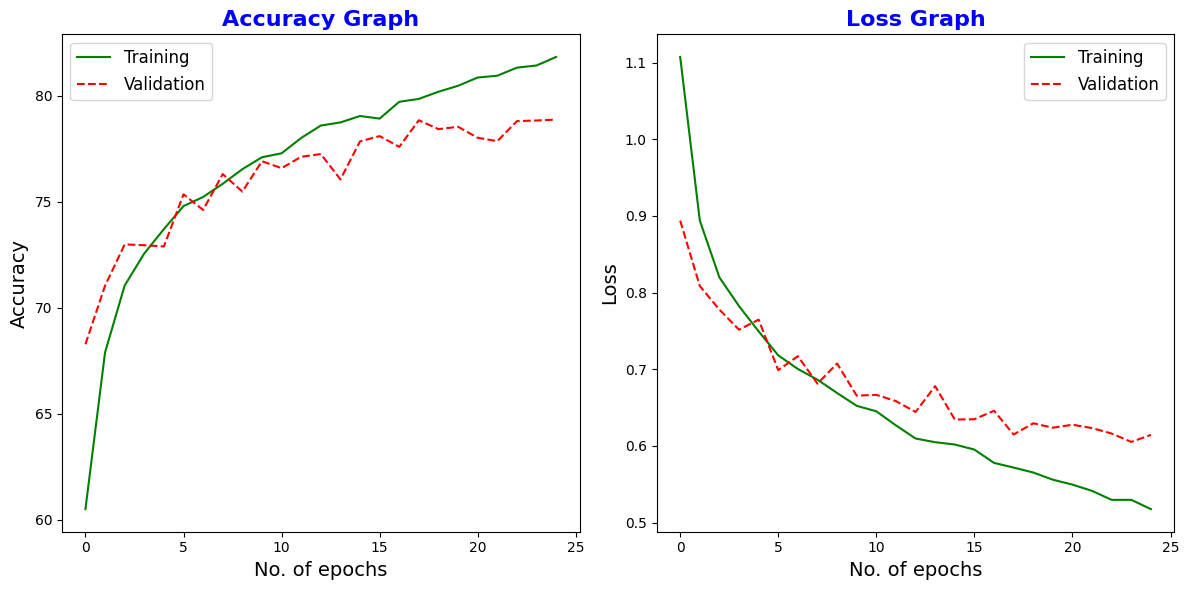

In [20]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_results.csv", num_epochs = 25)


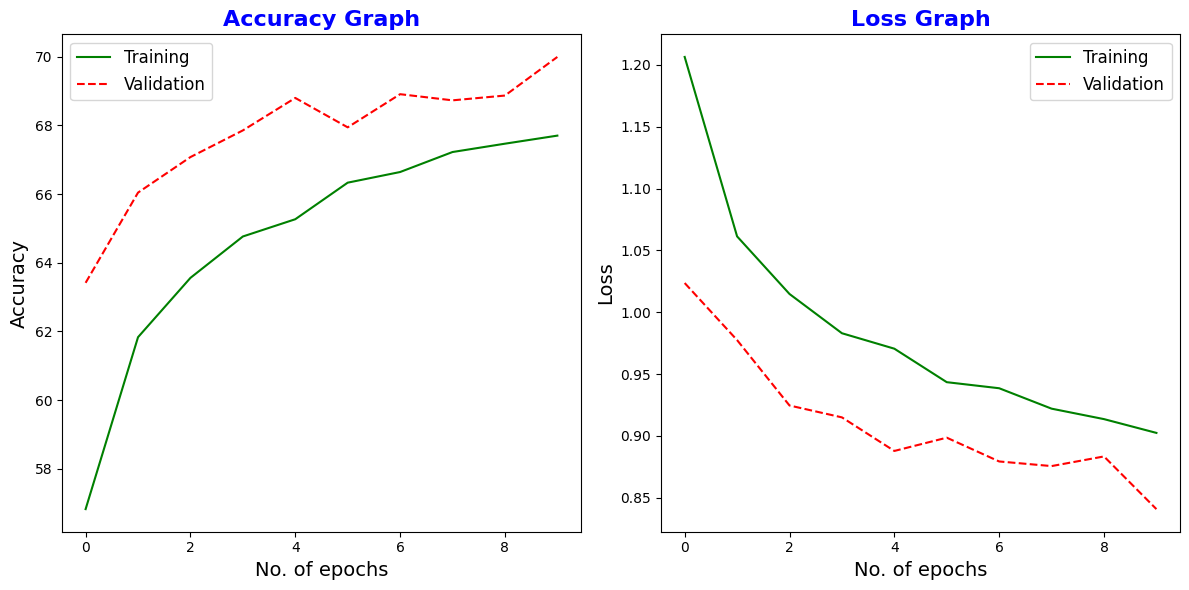

In [18]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_frozen_model_results.csv", num_epochs = 10)

> Note: Due to the long runtime of approximately seven hours on the CPU, I only completed 10 epochs for the code in section 4.2.

#### Feedback:
The AlexNet model trained on CIFAR10 did really well, scoring 78.8% accuracy on the validation set, which shows it performs effectively. There were no problems like overfitting or underfitting, as the loss decreased consistently for both the training and validation data. On the flip side, when we froze some layers in the AlexNet model, turning it into basically a multilayer perceptron (MLP) without convolutional layers, the accuracy dropped to 70% on the validation set. This happened because MLPs aren't great for classifying images. So, it's clear that the AlexNet model trained on CIFAR10 is the best choice for this task.


### Part II: Image Captioning using RNN [30 marks]



### Motivation 

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here! 

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make a two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``). 

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary 

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [111]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from IPython.display import HTML
from PIL import Image
from tqdm.notebook import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


**Please refer to the submission section at the top of this notebook to prepare your submission.**


In [43]:
# Load the feature map provided to you
features_map = torch.load('/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/Part2_DLAssessment_FeatureResNet50/resnet50_caption.pt', map_location=device) 

#### 5 Train DecoderRNN [20 marks]

> 5.1 Design a RNN-based decoder (10 marks)

> 5.2 Train your model with precomputed features (10 Marks)

##### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [44]:
import json
import pandas as pd

with open('/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/COMP5625M_data_assessment_2/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [45]:
coco_subset = pd.read_csv("/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/COMP5625M_data_assessment_2/coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

,image_id,id,caption,file_name
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
16758,9,663627,there are containers filled with different kin...,000000000009.jpg
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg


In [47]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
16758,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [48]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:3547, validation:506, test:1015


In [49]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [50]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [51]:
### build vocabulariy for each set - train, val and test 
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2384


In [52]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

2542

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 


In [53]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [54]:
# ''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct)
# features = torch.load("coco_features.pt")

# also load the model ckpt and udate the model state dict of the base model
# ---> your entry here (make sure that the path is correct)
# checkpoint = torch.load("ckpt file here") 
# model.load_state_dict(checkpoint['model_state_dict'])

In [55]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [56]:
# say this is as below 
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [57]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # Linear layer to resize        
        self.linear = nn.Linear(2048, embed_size)
        
        # batch normalisation         
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
        # Eembedding layer         
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # RNN Layer
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        # linear layer         
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.linear(features)
        im_features = self.bn(im_features)
        
        # Concatenate image features and caption embeddings as input to the RNN
        inputs = torch.cat((im_features.unsqueeze(dim=1), embeddings), dim=1)
        
        # Pack padded sequences
        packed = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through RNN
        output, _ = self.rnn(packed)
        
        # Pass through output layer
        outputs = self.fc(output.data)
        
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = self.bn(self.linear(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)              
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids


In [58]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [59]:
# loss and optimizer here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.0001
)

# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS, 2))
print(stats.shape)
total_loss = 0

for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        features_ = features_.to(device)
        captions_ = captions_.to(device)
        
        # Reset gradients
        decoder.zero_grad()

        # Forward pass
        outputs = decoder(features_, captions_, lengths_)

        # Compute the loss
        targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
        loss = criterion(outputs.view(-1, len(vocab)), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")

    stats[epoch, 0] = round(total_loss / total_step, 3)
    total_loss = 0

    decoder.eval()
    with torch.no_grad():
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            features_ = features_.to(device)
            captions_ = captions_.to(device)

            outputs = decoder(features_, captions_, lengths_)

            # Compute the loss
            targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
            loss = criterion(outputs.view(-1, len(vocab)), targets)

            total_loss += loss.item()

    stats[epoch, 1] = round(total_loss / total_step_v, 3)
    total_loss = 0

    # Print stats
    print("=" * 30)
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch, 0]}, Valid_Loss: {stats[epoch, 1]}")
    print("=" * 30)

    decoder.train()


(5, 2)
Epoch [1/5], Step [0/555], Loss: 7.8762
Epoch [1/5], Step [10/555], Loss: 7.7668
Epoch [1/5], Step [20/555], Loss: 7.6186
Epoch [1/5], Step [30/555], Loss: 7.3811
Epoch [1/5], Step [40/555], Loss: 6.7498
Epoch [1/5], Step [50/555], Loss: 6.2149
Epoch [1/5], Step [60/555], Loss: 5.8684
Epoch [1/5], Step [70/555], Loss: 5.8953
Epoch [1/5], Step [80/555], Loss: 5.6263
Epoch [1/5], Step [90/555], Loss: 5.6450
Epoch [1/5], Step [100/555], Loss: 5.4458
Epoch [1/5], Step [110/555], Loss: 5.3115
Epoch [1/5], Step [120/555], Loss: 5.3188
Epoch [1/5], Step [130/555], Loss: 5.3935
Epoch [1/5], Step [140/555], Loss: 5.3467
Epoch [1/5], Step [150/555], Loss: 5.1503
Epoch [1/5], Step [160/555], Loss: 5.2644
Epoch [1/5], Step [170/555], Loss: 5.2734
Epoch [1/5], Step [180/555], Loss: 5.0942
Epoch [1/5], Step [190/555], Loss: 5.3384
Epoch [1/5], Step [200/555], Loss: 5.2550
Epoch [1/5], Step [210/555], Loss: 5.4011
Epoch [1/5], Step [220/555], Loss: 5.0245
Epoch [1/5], Step [230/555], Loss: 4.9

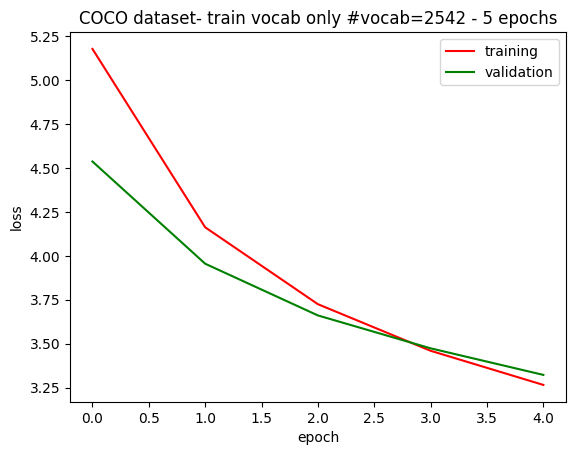

In [60]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [61]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation [10 marks] 

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [64]:
from PIL import Image
IMAGE_DIR = "/Users/shrichandbhuria/Downloads/All Modules/Sem_2/Deep Learning/CW1/COMP5625M_data_assessment_2/coco/images"

class COCOImagesDataset(Dataset):
    """
    COCOImagesDataset is a PyTorch Dataset class for loading the COCO images.
    
    Args:
        df : Coco Images Dataframe
        transform : A transform that takes in a PIL image and returns a transformed version of it.

    Returns:
        tuple: Tuple containing the loaded and transformed image and the name of the image file.

    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        """
            Retrieves the image at the given index and returns the Tuple containing the loaded and 
            transformed image and the name of the image file
        """
        filename = self.df.iloc[index]['file_name']
        image_path = os.path.join(IMAGE_DIR, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert numpy array to PIL Image
        if self.transform is not None:
            image = self.transform(image)
        return image, filename
    
    def __len__(self):
        # Returns the total number of images in the dataset.
        return len(self.df)


In [85]:
data_transform = transforms.Compose([ 
    transforms.Resize(224),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [86]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

DecoderRNN(
  (linear): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2542, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=2542, bias=True)
)

In [87]:
import torch
from torchvision import transforms
from PIL import Image
from helperDL import timshow  # Assuming this is a helper function for displaying images

# Define the transformation for preprocessing the images
data_transform = transforms.Compose([ 
    transforms.Resize(224),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet normalization
])

# Function to generate caption for a single image
def generate_caption(image_tensor, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass through the model
        output = model(image_tensor.unsqueeze(0))
        # Decode the output to get the generated caption
        generated_caption = decode_caption(output)  # You need to implement this function
    return generated_caption


In [88]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

In [ ]:
IMAGES_TO_SHOW = 4
idx = 0

with torch.no_grad():
    for i, (image, filename) in enumerate(test_loader):
        # Apply image transformation
        image = image_transform(image)

        # Add batch dimension if needed
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        # Generate caption for the image
        output = model(image)
        generated_caption = decode_caption(output, vocab)  # Pass the vocab argument

        # Display generated caption and image
        print("GENERATED:")
        print(generated_caption)
        print("\nREFERENCES:")
        print("===============================")

        # Show the image
        imshow(image[0].cpu())
        plt.show()

        idx += 1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Function to get the embedding of a caption
def get_caption_embeddings(caption):
    embeddings = []
    for word in caption:
        try:
            idx = vocab.word2idx[word]
            embedding = decoder.embed(torch.tensor([idx]).to(device)).squeeze().detach().cpu().numpy()
            embeddings.append(embedding)
        except KeyError:
            pass
    if len(embeddings) == 0: 
        return np.zeros(decoder.embed.embedding_dim)
    else:
        return np.mean(embeddings, axis=0)

# Initialize an empty list to store cosine similarity scores
cosine_sim_scores = []

# Iterate over the test set predictions
for i in range(len(stats_df)):
    ref_caption = stats_df.loc[i, 'ref']
    gen_caption = stats_df.loc[i, 'preds']
    
    # Compute the embedding vector for the generated caption
    gen_avg_embedding = get_caption_embeddings(gen_caption.split())
    
    cosine_scores = []
    
    # Compute cosine similarity scores for each reference caption
    for ref in ref_caption:
        ref_avg_embedding = get_caption_embeddings(ref.split())
        cosine_sim = cosine_similarity(ref_avg_embedding.reshape(1, -1), gen_avg_embedding.reshape(1, -1))
        cosine_scores.append(cosine_sim[0][0])
    
    # Calculate the average cosine similarity score for the generated caption
    avg_cos_score = np.mean(cosine_scores)
    cosine_sim_scores.append(avg_cos_score)

# Convert the list of cosine similarity scores to a numpy array
cosine_sim_scores = np.array(cosine_sim_scores)

# Display a histogram of the distribution of scores over the test set
plt.hist(cosine_sim_scores, bins=20, edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()


##### Thank you for completing the assessment - if you have any question, please ask on teams channel or attend lab sessions on Tuesdays and Wednesdays.